In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

Loading all data into DataFrame (Used only once to pickle)

In [2]:
def load_data():
    path = Path('data')
    df = []
    for folder in path.iterdir():
        activity = str(folder.name)
        data = pd.concat((pd.read_csv(file) for file in folder.iterdir()), ignore_index=True)
        data['activity'] = activity
        df.append(data)
    df = pd.concat(df)
    df.to_pickle('all_data.pkl')

In [3]:
df = pd.read_pickle('all_data.pkl')
df

,accelerometer_X,accelerometer_Y,accelerometer_Z,activity
0,1.000776,4.616021,8.576031,idle
1,0.718261,4.209007,8.446744,idle
2,-0.909797,-0.282516,9.203311,idle
3,5.099650,0.148441,8.418014,idle
4,1.762132,-0.162806,9.251195,idle
...,...,...,...,...
55495,5.109226,-15.452178,-1.470040,walking
55496,6.373365,-11.741165,-8.226476,walking
55497,3.289633,-9.993398,-0.383072,walking
55498,-2.978387,-3.050213,1.273715,walking


In [4]:
X = df.drop('activity', axis = 1)
y = df['activity']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

In [15]:
activities = df['activity'].unique()

In [5]:
%%time
svc = SVC().fit(X_train, y_train)
y_test_predicted_svc = svc.predict(X_test)

CPU times: total: 20min 17s
Wall time: 21min 12s


In [6]:
%%time
rfc = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
y_test_predicted_rfc = rfc.predict(X_test)

CPU times: total: 28.4 s
Wall time: 29.7 s


Classification report for SVC

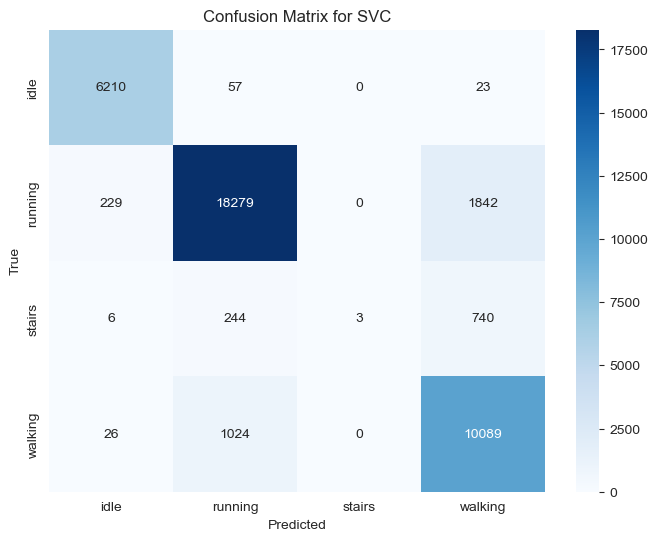

              precision    recall  f1-score   support

        idle       0.96      0.99      0.97      6290
     running       0.93      0.90      0.92     20350
      stairs       1.00      0.00      0.01       993
     walking       0.79      0.91      0.85     11139

    accuracy                           0.89     38772
   macro avg       0.92      0.70      0.69     38772
weighted avg       0.90      0.89      0.88     38772


In [24]:
svc_confusion_matrix = confusion_matrix(y_test, y_test_predicted_svc)
svc_classification_report = classification_report(y_test, y_test_predicted_svc)
plt.figure(figsize=(8, 6))
sns.heatmap(svc_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=activities, yticklabels=activities)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for SVC")
plt.show()
print(svc_classification_report)

Classification report for RFC(RandomForrestClassifier)

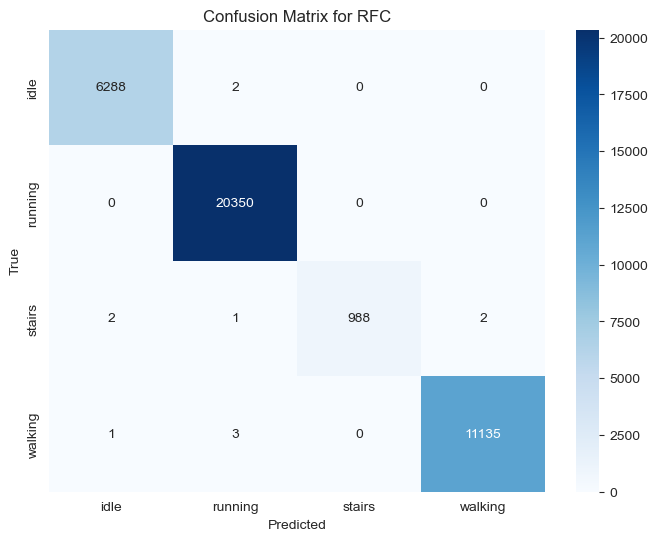

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6290
     running       1.00      1.00      1.00     20350
      stairs       1.00      0.99      1.00       993
     walking       1.00      1.00      1.00     11139

    accuracy                           1.00     38772
   macro avg       1.00      1.00      1.00     38772
weighted avg       1.00      1.00      1.00     38772


In [27]:
rfc_confusion_matrix = confusion_matrix(y_test, y_test_predicted_rfc)
rfc_classification_report = classification_report(y_test, y_test_predicted_rfc)
plt.figure(figsize=(8, 6))
sns.heatmap(rfc_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=activities, yticklabels=activities)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for RFC")
plt.show()
print(rfc_classification_report)

In [86]:
def entropy(data):
    hist, bins = np.histogram(data, bins='auto')
    probs = hist / len(data)
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs))

def interquartile_range(data):
    return data.quantile(0.75) - data.quantile(0.25)

def mean_of_absolute_deviation(data):
    return abs(data - data.mean()).mean()

def root_mean_square_error(data):
    mean = np.mean(data)
    squared_errors = [(x - mean) ** 2 for x in data]
    return np.sqrt(np.mean(squared_errors))
    

attr_agg_funcs = {
    'accelerometer_X': ['max', 'min', entropy, interquartile_range],
    'accelerometer_Y': ['max', 'idxmin', mean_of_absolute_deviation, 'median', 'skew','std', root_mean_square_error],
    'accelerometer_Z': ['skew']
}

time_domain_features = df.groupby(["activity", df.index // 10]).agg(attr_agg_funcs)
time_domain_features.reset_index(level=0, inplace=True)
time_domain_features

activity accelerometer_X                                          \
                          max       min   entropy interquartile_range   
0        idle        5.099650 -0.909797  1.770951            1.045069   
1        idle       -0.081403 -0.148441  2.121928            0.019154   
2        idle        0.407014 -0.320823  2.321928            0.099359   
3        idle        0.407014 -0.320823  2.446439            0.075417   
4        idle        0.014365 -0.167594  1.960964            0.021548   
...       ...             ...       ...       ...                 ...   
5545  walking        7.192182 -4.577713  2.246439            4.656722   
5546  walking       11.113884 -7.359776  2.170951            5.256470   
5547  walking        4.711789 -4.577713  2.121928            5.078101   
5548  walking        7.192182 -1.647211  2.246439            2.693477   
5549  walking       11.113884 -7.359776  2.246439            6.985083   

     accelerometer_Y                                                         \
                 max idxmin mean_of_absolute_deviation     median      skew   
0           4.616021      2                   1.453568  -0.136469  1.775835   
1          -0.105345     16                   0.010918  -0.129287  0.177861   
2           0.023942     25                   0.051140  -0.155623  1.192431   
3           0.023942     37                   0.052864  -0.155623  1.104844   
4          -0.057461     42                   0.015802  -0.124498  2.006087   
...              ...    ...                        ...        ...       ...   
5545        0.181959  55452                   5.606263  -9.028534 -0.717428   
5546       -4.161122  55466                   3.202676 -11.307814 -0.102964   
5547       -5.262455  55479                   3.990176 -11.681310  0.114141   
5548        0.181959  55480                   4.889726 -10.747571 -0.790122   
5549       -3.050213  55494                   3.822104  -9.959879 -0.150068   

                                      accelerometer_Z  
           std root_mean_square_error            skew  
0     1.920752               1.822185       -0.621408  
1     0.013951               0.013235       -0.705422  
2     0.075220               0.071360       -2.276230  
3     0.075873               0.071979        0.202356  
4     0.025463               0.024157       -2.195365  
...        ...                    ...             ...  
5545  7.343007               6.966188        1.373266  
5546  4.278525               4.058965       -0.635327  
5547  4.575814               4.340998       -1.954041  
5548  6.921799               6.566595        1.488368  
5549  5.072306               4.812012       -1.045833  

[19386 rows x 13 columns]

In [89]:
X = time_domain_features[['accelerometer_X',  'accelerometer_Y',  'accelerometer_Z']]
y = time_domain_features['activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y)

In [90]:
%%time
svc = SVC().fit(X_train, y_train)
y_test_predicted_svc = svc.predict(X_test)

CPU times: total: 20.8 s
Wall time: 21.4 s


In [91]:
%%time
rfc = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
y_test_predicted_rfc = rfc.predict(X_test)

CPU times: total: 3.64 s
Wall time: 3.92 s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


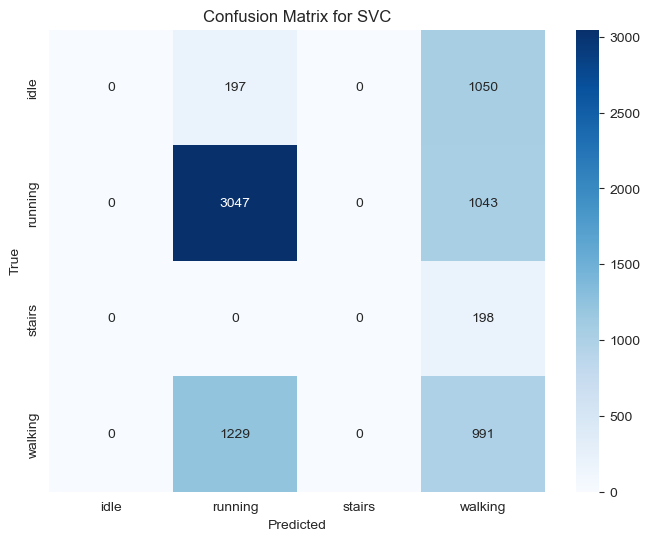

              precision    recall  f1-score   support

        idle       0.00      0.00      0.00      1247
     running       0.68      0.74      0.71      4090
      stairs       0.00      0.00      0.00       198
     walking       0.30      0.45      0.36      2220

    accuracy                           0.52      7755
   macro avg       0.25      0.30      0.27      7755
weighted avg       0.45      0.52      0.48      7755


In [92]:
svc_confusion_matrix = confusion_matrix(y_test, y_test_predicted_svc)
svc_classification_report = classification_report(y_test, y_test_predicted_svc)
plt.figure(figsize=(8, 6))
sns.heatmap(svc_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=activities, yticklabels=activities)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for SVC")
plt.show()
print(svc_classification_report)

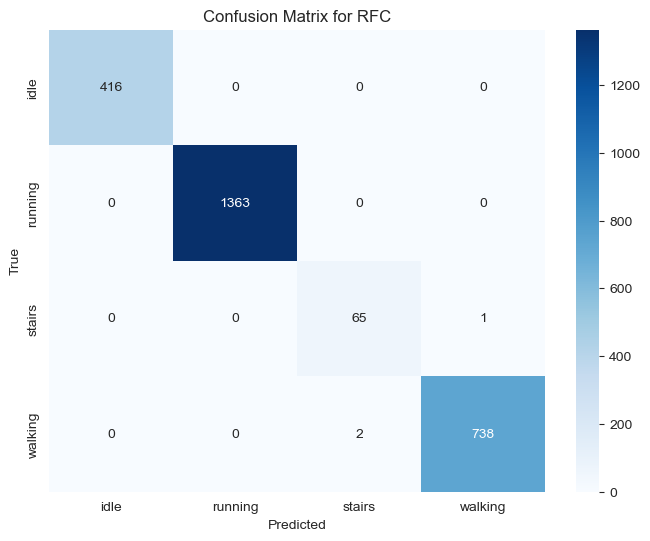

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       416
     running       1.00      1.00      1.00      1363
      stairs       0.97      0.98      0.98        66
     walking       1.00      1.00      1.00       740

    accuracy                           1.00      2585
   macro avg       0.99      1.00      0.99      2585
weighted avg       1.00      1.00      1.00      2585


In [80]:
rfc_confusion_matrix = confusion_matrix(y_test, y_test_predicted_rfc)
rfc_classification_report = classification_report(y_test, y_test_predicted_rfc)
plt.figure(figsize=(8, 6))
sns.heatmap(rfc_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=activities, yticklabels=activities)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for RFC")
plt.show()
print(rfc_classification_report)